In [1]:
import glob, os
import dicom_numpy
import dicom
import xml.etree.ElementTree as ET
from matplotlib import pyplot as plt
import numpy as np
import collections

In [2]:
def extract_voxel_data(list_of_dicom_files):
    datasets = [dicom.read_file(f) for f in list_of_dicom_files]
    try:
        voxel_ndarray, ijk_to_xyz, slices = dicom_numpy.combine_slices(datasets)
    except dicom_numpy.DicomImportException as e:
        # invalid DICOM data
        raise
    return voxel_ndarray, slices

In [3]:
def generate_labels_from_xml(xml, shape_to_return, k_to_z):
    labeled = np.zeros(shape_to_return)
    
    tree = ET.parse(xml)
    root = tree.getroot()
    ns = {}
    ns['main'] = 'http://www.nih.gov'
    for nodule in root.findall('main:readingSession/main:unblindedReadNodule', ns):
        for node in nodule.findall('main:roi',ns):
            z = k_to_z[float(node.find('main:imageZposition',ns).text)]
            row_list = collections.defaultdict(list)
            for edge in node.findall('main:edgeMap',ns):
                x,y = int(edge[0].text), int(edge[1].text)
                labeled[x,y,z] = 1.
                row_list[x] += [y]
            # get first and last occurance of '1' in each row and fill indicies in between with all ones
            for xs in row_list.keys():
                labeled[xs,min(row_list[xs]):max(row_list[xs]),z].fill(1)
        break
    return labeled

In [4]:
primary = os.path.join(".","data","LIDC-IDRI")
patient_folders = [os.path.join(primary,f) for f in os.listdir(primary) if os.path.isdir(os.path.join(primary, f))]

In [5]:
patient_dicoms_dir = []
for sample in patient_folders:
    len_list = [len(os.listdir(os.path.join(sample,fil,os.listdir(os.path.join(sample, fil))[0]))) for fil in os.listdir(sample)]
    correct_file = os.path.join(sample, os.listdir(sample)[len_list.index(max(len_list))])
    patient_dicoms_dir.append(os.path.join(correct_file,os.listdir(correct_file)[0]))

In [13]:
from keras import layers, models

In [104]:
model = models.Sequential()
model.add(layers.Conv2D(10, (3, 3), activation='relu', input_shape=(512, 512, 1)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2DTranspose(10, (3, 3)))
model.add(layers.Conv2DTranspose(1, (256, 256)))
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_47 (Conv2D)           (None, 510, 510, 10)      100       
_________________________________________________________________
max_pooling2d_24 (MaxPooling (None, 255, 255, 10)      0         
_________________________________________________________________
conv2d_transpose_30 (Conv2DT (None, 257, 257, 10)      910       
_________________________________________________________________
conv2d_transpose_31 (Conv2DT (None, 512, 512, 1)       655361    
Total params: 656,371
Trainable params: 656,371
Non-trainable params: 0
_________________________________________________________________


In [109]:
model.compile(optimizer='rmsprop',
              loss='mse',
              metrics=['accuracy'])

In [ ]:
for idx, sample in enumerate(patient_dicoms_dir):
    PathDicom = sample
    lstFilesDCM = []
    for dirName, subdirList, fileList in os.walk(PathDicom):
        for filename in fileList:
            if ".dcm" in filename.lower():  # check whether the file's DICOM
                lstFilesDCM.append(os.path.join(dirName,filename))
                
    # data contains (a,b,c) ndarray, slices contains k coordinate of lstFilesDCM
    data, slices  = extract_voxel_data(lstFilesDCM)
    # k to z voxel mapping
    k_to_z = {k:v for v,k in enumerate(sorted(slices))}
    
    label_xml = glob.glob(os.path.join(PathDicom,"*.xml"))
    y = generate_labels_from_xml(label_xml[0], data.shape, k_to_z)
    
    data = data.T
    y = y.T
    
    model.train_on_batch(data.reshape(data.shape[0], data.shape[1], data.shape[2], 1),y.reshape(y.shape[0], y.shape[1], y.shape[2], 1))
    break

In [53]:
.shape

(512, 512, 1)

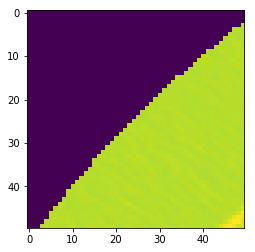

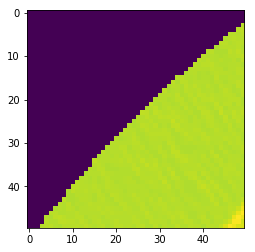

In [68]:
plt.imshow(data.T[0,50:100,50:100])
plt.show()
plt.imshow(data[50:100,50:100,0])
plt.show()